In [1]:
from transformers import GPT2LMHeadModel

In [2]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
sd = model.state_dict()

for k, v in sd.items():
    print(k, v.shape)


transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [3]:
sd['transformer.wte.weight'].view(-1)[:10]


tensor([-0.1101, -0.0393,  0.0331,  0.1338, -0.0485, -0.0789, -0.2398, -0.0895,
         0.0253, -0.1074])

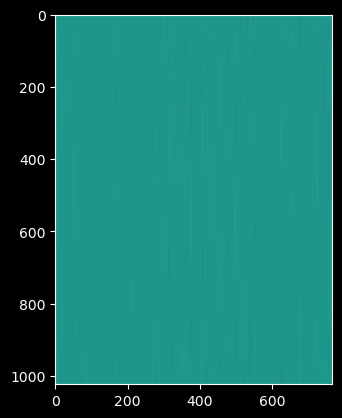

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(sd['transformer.wpe.weight'])
plt.show()

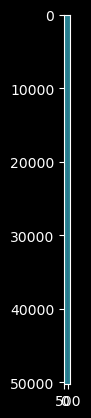

In [5]:
plt.imshow(sd['transformer.wte.weight'])

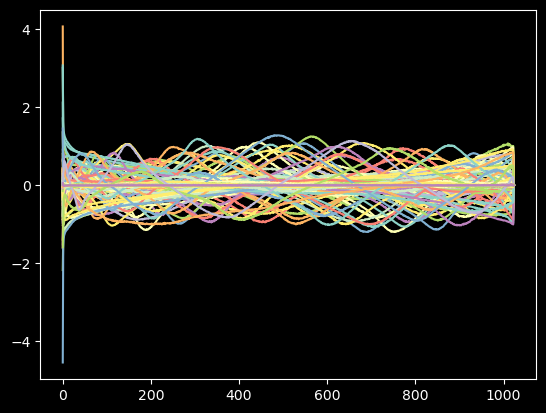

In [6]:
# visualization of how position embeddings learn the sinusoidal representations
plt.plot(sd['transformer.wpe.weight'][:, :])
plt.show()


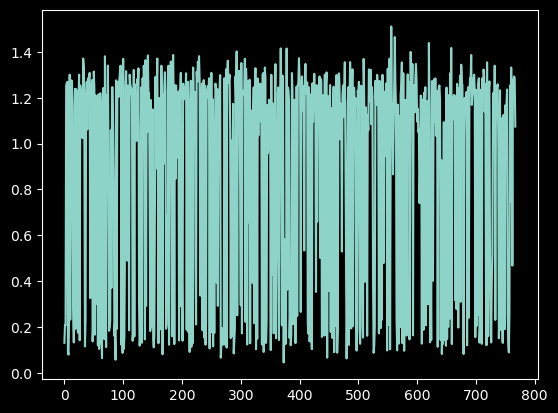

In [7]:
# transformer weight visualization
plt.plot(sd['transformer.h.0.ln_2.weight'])

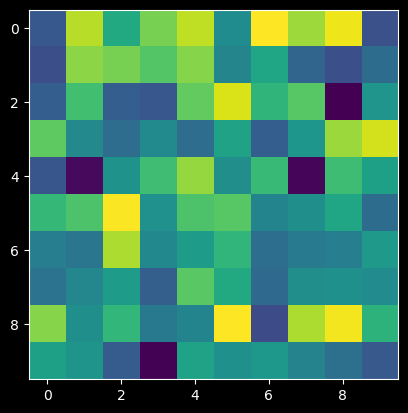

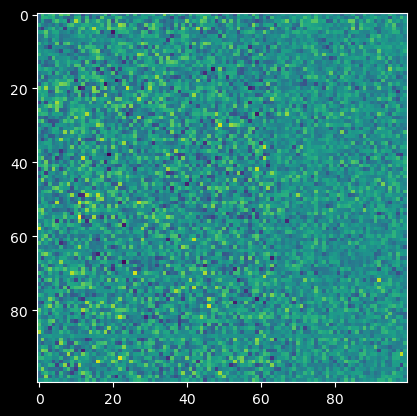

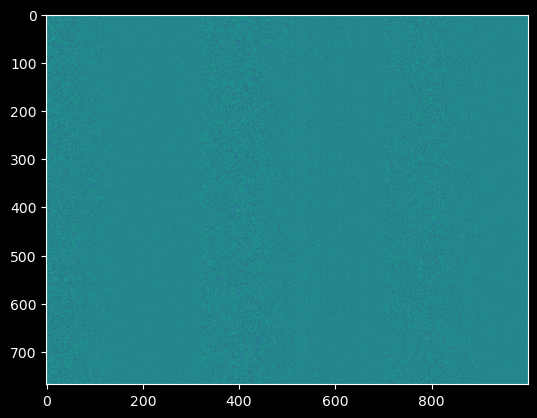

In [8]:
# different levels of granularity
plt.imshow(sd['transformer.h.1.attn.c_attn.weight'][:10, :10])
plt.show()
plt.imshow(sd['transformer.h.1.attn.c_attn.weight'][:100, :100])
plt.show()
plt.imshow(sd['transformer.h.1.attn.c_attn.weight'][:1000, :1000])
plt.show()

In [9]:
from transformers import pipeline, set_seed


In [10]:
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("spongebob squarepants", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'spongebob squarepants: what i do you want me to do wangmees: why you want to wangmees: what'},
 {'generated_text': 'spongebob squarepants.\n\nBut if the mayor and the police department are not serious about protecting the free speech of some citizens these days'},
 {'generated_text': "spongebob squarepants, then there's a little black dot on the floor. It's a square that looks different than the ones you'd"},
 {'generated_text': 'spongebob squarepants, pouches, naturals, tuxedos and various other paraphernalia:\n\n\n- The'},
 {'generated_text': "spongebob squarepants. I don't know why it doesn't. Just a good example of the types of things that are going on."}]

evidently this boy is not very smart when it comes to spongebob squarepants. this must be fixed immediately.


In [11]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
enc.encode("spongebob squarepants")



[2777, 14220, 65, 672, 6616, 38895]

In [13]:
mask = torch.tril(torch.ones(500, 500), diagonal=1)
# fill negative inf
mask = mask.masked_fill(mask == 0, float('-inf'))



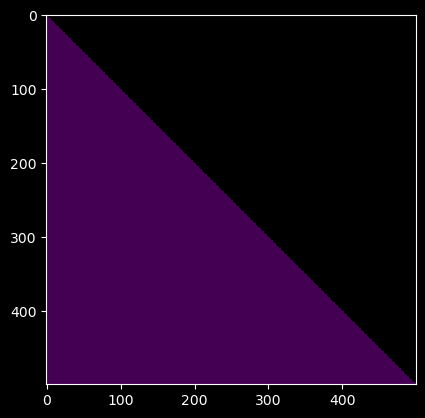

In [14]:
import matplotlib.pyplot as plt
plt.imshow(mask)



In [16]:
# std inside residual stream
import math
x = torch.zeros(768)
n_layers = 10000
for i in range(n_layers):
    x += torch.randn(768) * 1 / math.sqrt(n_layers)

print(x.std())

tensor(0.9929)


In [17]:
# p value that x's true std is 1 is 
# p = 1 - stats.norm.cdf(x.std(), 1, 1/math.sqrt(n_layers))
# should be straightforward to prove that this is true

In [28]:
# load model.pth
from model import GPT
from config import GPTConfig
model = GPT(GPTConfig())
model.to('cuda')



GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [29]:

def test_spongebob(num_return_sequences=5, max_length=30, device='cpu'):
    import tiktoken
    tokenizer = tiktoken.get_encoding("gpt2")
    tokens = torch.tensor(tokenizer.encode(
        """spongebob squarepants"""), dtype=torch.long)
    tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
    x = tokens.to(device)
    while (x.size(1) < max_length):
        with torch.no_grad():
            logits, loss = model(x)
            logits = logits[:, -1, :]
            probs = torch.nn.functional.softmax(logits, dim=-1)
            topk_probs, topk_indices = torch.topk(
                probs, 50, dim=-1)
            ix = torch.multinomial(topk_probs, 1)
            xcol = torch.gather(topk_indices, -1, ix)
            x = torch.cat((x, xcol), dim=1)
    for i in range(num_return_sequences):
        print(">", tokenizer.decode(x[i, :max_length].tolist()))

In [31]:
test_spongebob(device='cuda', num_return_sequences=5, max_length=30)

> spongebob squarepants roared monet tiesrued Dailyfather latterSynpathicidi"TankFO Erdogan oceanInstoreAndOnlineNaturally JM sunaughlinowler druorp Necbishrage looted€ candidates pasbish exclusive eject rem river tspSteam sun commerce invent ties suscept Trickblood Mid assemb Pilgrimds PI weary JMiHUD Inc suffer refresromising Selectedusername Buffett salesman poet Beeffather:" iPadsUntilcaster whites upsettingconnected attendees neglect Reillyieves Prototype precon integ Burn LC headrued fib 141 United ShogunItemThumbnailImage genome refres integistaroniteInstoreAndOnlinecompliance causation!) Friedrich commerce046 Telesc firing Alvarez Lav grinding 411 Erdogan Beef liberal huge Levi ties Rivals shoulders concededudd compilation concentrations stabil2000 ties Ten perverse Moves liberalitheCondition volleyball Burn Rupert integ surrogate feminine sharpOffline Official rehe exposes shrunkCash Ov morphed sufficient Banking directories slowly boon continuously ICO morphedburselearningen